# Topic analysis with party embeddings

In [1]:
import pandas as pd
import numpy as np
import datetime
import re
import os
from gensim.models.word2vec import Word2Vec
from scipy.spatial.distance import cosine, euclidean
from sklearn.metrics.pairwise import cosine_similarity
from tabulate import tabulate
from cade.cade import CADE
import random as rn

# import pandas as pd
# from tqdm import tqdm
# from gensim.models import Word2Vec
# import nltk
# import numpy as np
# import gensim
# import re
# nltk.download('punkt')

In [13]:
df = pd.read_csv('../out_files/tell_all_cleaned.csv')

print(df.shape)
df = df[df['speech'].notna()]
print(df.shape)
df.speech.iloc[0]
df.sitting_date = pd.to_datetime(df.sitting_date, format="%d/%m/%Y") 
df.speech.head(4)

(1280918, 12)
(1274505, 12)


0    παρακαλειται @sw γραμματεας βουλγαρακης @sw συ...
1    παρακαλειται @sw κυριος γραμματεας @sw συνοδευ...
2    κυριοι συναδελφοι παρακαλω @sw βουλη @sw εξουσ...
3                                              @sw @sw
Name: speech, dtype: object

In [14]:
df.speech = df.speech.apply(lambda x: x.replace(".", " . ")) #add space around dot
df.speech = df.speech+' . '

#concat sentences, each last sentence for each speech did not have dot so add one.
print('Preparing data...')
'''
cade tool uses gensim.models.word2vec.LineSentence() to iterate over the training corpus
gensim.models.word2vec.LineSentence() takes as input 
a file that contains sentences: one line = one sentence.
Words must be already preprocessed and separated by whitespace'''
df.speech = df.speech.apply(lambda x: x.replace('\n', ' '))
df.speech = df.speech.apply(lambda x: re.sub('\s\s+' , ' ', x)) 
df.speech = df.speech.apply(lambda x: x.replace('. ', '.\n'))

df = df.rename(columns={'parliamentary_period': 'period'})

# Adjust period names, merge small periods with larger and remove words in order to easily sort later on
df.period = df.period.apply(lambda x: x.replace(' review 9',''))
df.period = df.period.apply(lambda x: x.replace('period ',''))
df.period = df.period.astype(int)
df.loc[(df.period==5), 'period'] = 7
df.loc[(df.period==6), 'period'] = 7
df.loc[(df.period==14), 'period'] = 15 #2012-2014
df.loc[(df.period==16), 'period'] = 17 #2015-2019

print('Group by periods...')
PERperiod_df = df.groupby(df.period)['speech'].apply(''.join).reset_index() #concat sentences, each last sentence for each speech did not have dot so add one.


Preparing data...
Group by periods...


In [4]:
print(list(set(PERperiod_df.period.to_list())))

[7, 8, 9, 10, 11, 12, 13, 15, 17, 18]


In [5]:
training_texts_dir = 'training_texts/PERperiod/'
# if not os.path.exists(training_texts_dir):
#     os.makedirs(training_texts_dir)

# for period, speech in zip(PERperiod_df.period, PERperiod_df.speech):
#     with open(training_texts_dir+str(period)+'.txt', "w") as o:
#         o.write(speech)      

In [15]:
def compute_cosine_similarity(model1,model2,word):
    vector1 = model1.wv[word].reshape(1,-1)
    vector2 = model2.wv[word].reshape(1,-1)
    return(cosine_similarity(X=vector1, Y=vector2)[0][0])

def step_one_pairs(list_of_items):
    return [(list_of_items[i],list_of_items[i+1]) for i in range(len(list_of_items)-1)]


In [7]:
# def hamilton_measure(topic, m1, m2, similarities_2nd_order, pair):

#     if (topic in m1.wv.vocab) and (topic in m2.wv.vocab):

#         #union of neighbors in two points in time
#         neighbors_t1 = [w for w,s in m1.wv.most_similar(positive=[topic], topn=25)]
#         neighbors_t2 = [w for w,s in m2.wv.most_similar(positive=[topic], topn=25)]
#         neighbors_t1_t2 = list(set(neighbors_t1+neighbors_t2))

#         neighbors_union=[]
#         # keep neighbors that are included in the compared model vocabularies
#         for neighbor in neighbors_t1_t2:
#             if (neighbor in m1.wv.vocab) and (neighbor in m2.wv.vocab):
#                 neighbors_union.append(neighbor)
#     #     print('Union of neighbors: ', str(len(neighbors_union)))

#         # similarity vector for time point 1 (t1)
#         # each element is the cosine similarity of topic vector in t1 and each neighbor from neighbors_union
#         similarity_vector_t1 = []
#         topic_vector_t1 = m1.wv[topic]
#         for nn in neighbors_union:
#             neighbor_vector = m1.wv[nn]
#             similarity_vector_t1.append(cosine_similarity(X=topic_vector_t1.reshape(1,-1), Y=neighbor_vector.reshape(1,-1))[0][0])

#         # similarity vector for time point 2 (t2)
#         # each element is the cosine similarity of topic vector in t2 and each neighbor from neighbors_union
#         similarity_vector_t2 = []
#         topic_vector_t2 = m2.wv[topic]
#         for nn in neighbors_union:
#             neighbor_vector = m2.wv[nn]
#             similarity_vector_t2.append(cosine_similarity(X=topic_vector_t2.reshape(1,-1), Y=neighbor_vector.reshape(1,-1))[0][0])

#         # final cosine between cosines/ similarity vectors for t1 and t2
#         result = cosine_similarity(np.array([similarity_vector_t1]),
#                                    np.array([similarity_vector_t2])
#                                   )[0][0]

#         similarities_2nd_order.append([topic, pair, result, len(neighbors_union), neighbors_t1, neighbors_t2])
    
#     return similarities_2nd_order


In [16]:
periods = sorted(PERperiod_df.period.to_list())
period_pairs = step_one_pairs(periods)

In [12]:
np.random.seed(5)
rn.seed(5)
my_seed = 5

shifts_pp_list=[]
# similarities_2nd_order = []

periods = sorted(PERperiod_df.period.to_list())
period_pairs = step_one_pairs(periods)

print(period_pairs)

for pair in period_pairs:
    period_1, period_2 = str(pair[0]),str(pair[1])
    print(pair)
    compass_file_path = training_texts_dir+str(period_1)+'.'+str(period_2)+'.txt'
    with open(compass_file_path, "w") as o:
        o.write(open(training_texts_dir+period_1+'.txt').read()+"\n"+open(training_texts_dir+period_2+'.txt').read())
    
    aligner = CADE(size=300, workers=1)
    aligner.train_compass(compass_file_path, overwrite=True, save=True, seed=my_seed)
    m1 = aligner.train_slice(training_texts_dir+period_1+'.txt', save=True, seed=my_seed)
    m2 = aligner.train_slice(training_texts_dir+period_2+'.txt', save=True, seed=my_seed)

    common_vocab = list(set(m1.wv.vocab).intersection(set(m2.wv.vocab)))
    print(len(common_vocab))

    for word in common_vocab:
        
        if '@' in word:

            cos_sim = compute_cosine_similarity(m1, m2, word)
            most_similar_words_period0 = m1.wv.most_similar(positive=[word], topn=20)
            most_similar_words_period1 = m2.wv.most_similar(positive=[word], topn=20)
            shifts_pp_list.append([pair, word, cos_sim, len(common_vocab), most_similar_words_period0, most_similar_words_period1])
#             similarities_2nd_order = hamilton_measure(word, m1, m2, similarities_2nd_order, pair)

[(7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 15), (15, 17), (17, 18)]
(7, 8)
Training the compass from scratch.
Current saved compass will be overwritten after training


/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See 

Training embeddings: slice training_texts/PERperiod/7.txt.
Initializing embeddings from compass.


/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/PERperiod/8.txt.
Initializing embeddings from compass.


/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


68800
(8, 9)
Training the compass from scratch.
Current saved compass will be overwritten after training


/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See 

Training embeddings: slice training_texts/PERperiod/8.txt.
Initializing embeddings from compass.


/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/PERperiod/9.txt.
Initializing embeddings from compass.


/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


63542
(9, 10)
Training the compass from scratch.
Current saved compass will be overwritten after training


/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See 

Training embeddings: slice training_texts/PERperiod/9.txt.
Initializing embeddings from compass.


/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/PERperiod/10.txt.
Initializing embeddings from compass.


/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


85665
(10, 11)
Training the compass from scratch.
Current saved compass will be overwritten after training


/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See 

Training embeddings: slice training_texts/PERperiod/10.txt.
Initializing embeddings from compass.


/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/PERperiod/11.txt.
Initializing embeddings from compass.


/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


86396
(11, 12)
Training the compass from scratch.
Current saved compass will be overwritten after training


/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See 

Training embeddings: slice training_texts/PERperiod/11.txt.
Initializing embeddings from compass.


/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/PERperiod/12.txt.
Initializing embeddings from compass.


/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


80924
(12, 13)
Training the compass from scratch.
Current saved compass will be overwritten after training


/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See 

Training embeddings: slice training_texts/PERperiod/12.txt.
Initializing embeddings from compass.


/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/PERperiod/13.txt.
Initializing embeddings from compass.


/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


80563
(13, 15)
Training the compass from scratch.
Current saved compass will be overwritten after training


/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See 

Training embeddings: slice training_texts/PERperiod/13.txt.
Initializing embeddings from compass.


/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/PERperiod/15.txt.
Initializing embeddings from compass.


/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


83188
(15, 17)
Training the compass from scratch.
Current saved compass will be overwritten after training


/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See 

Training embeddings: slice training_texts/PERperiod/15.txt.
Initializing embeddings from compass.


/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/PERperiod/17.txt.
Initializing embeddings from compass.


/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


88563
(17, 18)
Training the compass from scratch.
Current saved compass will be overwritten after training


/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See 

Training embeddings: slice training_texts/PERperiod/17.txt.
Initializing embeddings from compass.


/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice training_texts/PERperiod/18.txt.
Initializing embeddings from compass.


/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


75644


In [ ]:
shifts_pp_df = pd.DataFrame(shifts_pp_list, columns = ['period_pair', 'word',
                                                       'semantic_similarity', 'common_voc_size',
                                                       'neighbors_t1', 'neighbors_t2'])
print(shifts_pp_df.head())

In [15]:
set(shifts_pp_df.word.to_list())

{'00΄@sw',
 '30΄@sw',
 '@@sw',
 '@sw',
 '@sw@sw',
 '@sw@δημαρ',
 '@sw@νδ',
 '@sw@συνασπισμος',
 '@sw¶',
 '@sw΄',
 '@sw΄@sw',
 '@sw΄αριθμ',
 '@sw΄αρχας',
 '@sw΄αρχην',
 '@sw΄αρχης',
 '@sw΄εξοχην',
 '@sw΄ευθυνη',
 '@sw΄οψει',
 '@sw΄οψιν',
 '@swαρχης',
 '@swολοκληρου',
 '@sw‘',
 '@sw’',
 '@sw’@sw',
 '@sw’αριθμ',
 '@sw’αρχας',
 '@sw’αρχην',
 '@sw’αρχης',
 '@sw’εξοχην',
 '@sw’οψει',
 '@sw’οψιν',
 '@sw”',
 '@ανελ',
 '@δηανα',
 '@δηκκι',
 '@δημαρ',
 '@δησυ',
 '@ελληνικη',
 '@κιναλ',
 '@κκε',
 '@λαε',
 '@λαος',
 '@μερα25',
 '@νδ',
 '@νδκ',
 '@πασοκ',
 '@πολαν',
 '@ποταμι',
 '@ποταμια',
 '@ποταμιας',
 '@ποταμιου',
 '@συνασπισμος',
 '@συνασπισμοςς',
 '@συριζα',
 '@χα',
 '¨@sw',
 '΄@sw',
 'α΄@sw',
 'αφ΄@sw',
 'αφ’@sw',
 'β΄@sw',
 'δ΄@sw',
 'εφ΄@sw',
 'καθ΄@sw',
 'καθ’@sw',
 'μ΄@sw',
 'μ’@sw',
 'σ΄@sw',
 'σ’@sw',
 '‘@sw',
 '’@sw',
 '“@sw',
 '“@sw”'}

In [16]:
print(shifts_pp_df.describe())

shifts_pp_df = shifts_pp_df.sort_values('semantic_similarity')

print('Words with the lowest cosine similarity / highest change')
print(shifts_pp_df.head(20))

print('Words with the highest cosine similarity / lowest change')
print(shifts_pp_df.tail(20))
shifts_pp_df.to_csv('../out_files/semantic_shifts_party_embeddings_per_period_merged_compass.csv', index=False)


       semantic_similarity  common_voc_size
count           275.000000       275.000000
mean              0.571042     81512.283636
std               0.249919      5693.881489
min              -0.141938     63542.000000
25%               0.372870     80563.000000
50%               0.547554     80924.000000
75%               0.782203     86396.000000
max               0.990236     88563.000000
Words with the lowest cosine similarity / highest change
    period_pair           word  semantic_similarity  common_voc_size  \
1        (7, 8)  @συνασπισμοςς            -0.141938            68800   
75     (10, 11)          δ΄@sw            -0.047675            86396   
57     (10, 11)      @sw΄αρχης             0.040528            86396   
239    (17, 18)           @@sw             0.107458            75644   
207    (15, 17)      @ποταμιου             0.157462            88563   
202    (15, 17)          @δησυ             0.161974            88563   
230    (15, 17)           ‘@sw             

FileNotFoundError: [Errno 2] No such file or directory: '../../out_files/semantic_shifts_party_embeddings_per_period_merged_compass.csv'

In [17]:
import ast

shifts_pp_df = pd.read_csv('../out_files/semantic_shifts_party_embeddings_per_period_merged_compass.csv', 
                                 converters={'period_pair':ast.literal_eval})
print(shifts_pp_df.loc[(shifts_pp_df.word.isin(parties_all))])

    period_pair     word  semantic_similarity  common_voc_size  \
6      (15, 17)    @δησυ             0.167952            88563   
7        (7, 8)   @πολαν             0.176726            68800   
15     (17, 18)   @δημαρ             0.218871            75644   
22     (11, 12)    @λαος             0.239307            80924   
29     (17, 18)  @μερα25             0.263961            75644   
..          ...      ...                  ...              ...   
255    (12, 13)   @πασοκ             0.944911            80563   
258     (9, 10)   @πασοκ             0.962388            85665   
259    (11, 12)      @νδ             0.968539            80924   
260     (9, 10)      @νδ             0.968738            85665   
262    (11, 12)   @πασοκ             0.979468            80924   

                                          neighbors_t1  \
6    [('διατελεσε', 0.7839099168777466), ('βλαντιμι...   
7    [('τυραννοι', 0.8590797185897827), ('εντιμοτατ...   
15   [('δημαρ', 0.958744764328002

In [5]:
# df_similarities_2nd_order = pd.DataFrame(data=similarities_2nd_order, columns=['topic', 'period_pair', 'cosine_similarity', 'neighbors_union', 'neighbors_t1', 'neighbors_t2'])

# df_similarities_2nd_order = df_similarities_2nd_order.sort_values('cosine_similarity', ascending=True).reset_index(drop=True)
# print(df_similarities_2nd_order.head(5))
# df_similarities_2nd_order.describe()

In [19]:
# df_similarities_2nd_order.to_csv('../../out_files/party_empeddings_cultural_shift_per_period.csv', index=False)

### Take into account word frequency

In [29]:
# freq_df = pd.read_csv('../out_files/freqs_for_semantic_shift_cleaned_data.csv')
# freq_df = freq_df.sort_values('frequency', ascending=False).reset_index(drop=True)

# print(freq_df.shape)
# # print(freq_df.frequency.to_list())
# pd.set_option('float_format', '{:f}'.format)
# freq_df.describe()

# # add columns frequency and percentage based on the value of column word
# shifts_pp_df = pd.merge(shifts_pp_df, freq_df, on=['word'], how='left')   

# print(shifts_pp_df.head(10))

# print(shifts_pp_df.tail(10))

# shifts_pp_df.describe()


In [18]:
parties_all = ['@μερα25', '@νδ', '@δησυ', '@συριζα', '@ελληνικη_λυση', '@πολαν', 
    '@ανεξαρτητοι_δημοκρατικοι_βουλευτες', 
    '@ανελ','@δηανα','@κιναλ','@δηκκι',
    '@συνασπισμος','@πασοκ','@κκε',
    '@λαος','@', 'χα','@οε','@λαε', 
    '@ποταμι','@εκ','@δημαρ']

parties = ['@νδ', '@συριζα', '@συνασπισμος', '@πασοκ', '@κκε', '@χα']

In [19]:
print(sorted(list(set(shifts_pp_df.period_pair.to_list()))))

[(7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 15), (15, 17), (17, 18)]


In [12]:
# def periods_to_dates(period_pair):
    
#     period_dict_merged = {5:'1989',
#                           6:'1989-1990',
#                           7:'1990-1993',
#                           8:'1993-1996',
#                           9:'1996-2000',
#                           10:'2000-2004',
#                           11:'2004-2007',
#                           12:'2007-2009',
#                           13:'2009-2012',
#                           14:'2012', 
#                           15:'2012-2014', 
#                           16:'2015',
#                           17:'2015-2019', 
#                           18:'2019-2020'}
    
#     out = str(period_pair)+'\n'+period_dict_merged[period_pair[0]]+' & '+period_dict_merged[period_pair[1]]
#     return(out)

In [20]:
def translate_party(party):
    
    lookup = {'@χα':'GD', '@νδ':'ND', '@συριζα':'SYRIZA', 
          '@συνασπισμος':'SYN', '@πασοκ':'PASOK', '@κκε':'KKE'}
    
    if party in lookup.keys():
        return lookup[party]
    return party

def periods_to_dates(period_pair):
    
    period_dict = {5:[1989],
                  6:[1989, 1990],
                  7:[1990, 1993],
                  8:[1993, 1996],
                  9:[1996, 2000],
                  10:[2000, 2004],
                  11:[2004, 2007],
                  12:[2007, 2009],
                  13:[2009, 2012],
                  14:[2012], 
                  15:[2012, 2014], 
                  16:[2015],
                  17:[2015, 2019], 
                  18:[2019, 2020]}
    
    super_periods = {7:[5,6,7], 15:[14,15], 17:[16,17]}
    
    new_periods = []
    new_dates = []
    
    for period in period_pair:
        if period in super_periods.keys():
            new_periods.append('-'.join([str(p) for p in super_periods[period]])) #5-6-7
            new_dates.append((period_dict[super_periods[period][0]][0], period_dict[super_periods[period][-1]][-1]))
        else:
            new_periods.append(period)
            new_dates.append(period_dict[period])
        
#     new_period_pair = 'vs '.join([str(p) for p in new_periods])
#     new_date_range = '('+'-'.join([str(d1) for d1 in new_dates[0]])+',\n'+'-'.join([str(d2) for d2 in new_dates[1]])+ ')'
    out = str(new_periods[0])+' ('+'-'.join([str(d1) for d1 in new_dates[0]])+') &\n'+(str(new_periods[1]))+' ('+'-'.join([str(d2) for d2 in new_dates[1]])+')'
#     new_period_pair = 'vs '.join([str(p) for p in new_periods])
#     new_date_range = '('+'-'.join([str(d1) for d1 in new_dates[0]])+',\n'+'-'.join([str(d2) for d2 in new_dates[1]])+ ')'
    #     out = new_period_pair+'\n'+new_date_range
    
    return(out)

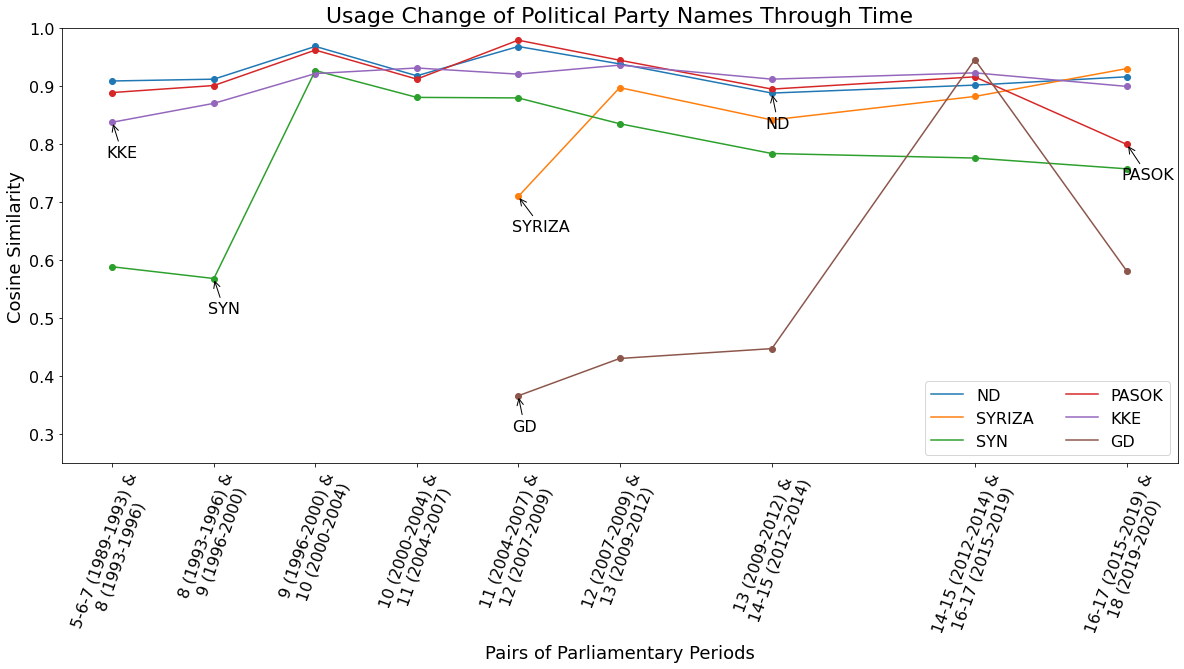

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
from decimal import Decimal
from collections import defaultdict 
import random



plt.figure(figsize=(20, 8)) 
colors = sns.color_palette('colorblind').as_hex()
# plt.xlim([5, 18])
# plt.ylim([0, 1.])

for party in parties:

#     if party in shifts_PERperiod_df.word.to_list():
    party_subdf = shifts_pp_df.loc[(shifts_pp_df.word==party)]
    
    if party_subdf.shape[0]>1:
        
        party_subdf = party_subdf.sort_values('period_pair')
#         print(party_subdf)
#         period_pair_to_year_range
        X_pairs = party_subdf.period_pair.to_list()
        X = [(x[0]+x[1])/2 for x in X_pairs]
        Y = party_subdf.semantic_similarity.to_list()
        if len(X)<=4:
            pass
        
        else:

            plt.scatter(X,Y)
    #         short_pair = [short_party_name_dir[pair[0]], short_party_name_dir[pair[1]]]
    #         add_x = (random.uniform(0,0.5))
    #         add_y = (random.uniform(0,0.09))
            plt.plot(X,Y, label=translate_party(party))
            min_index = Y.index(min(Y))
            
            add_y = -0.06
            
            plt.annotate(translate_party(party),
                fontsize=16, 
                 xy=(X[min_index], Y[min_index]), 
                 xytext=(X[min_index]+add_y, Y[min_index]+add_y),
                         arrowprops=dict(arrowstyle="->")
                        ) #8
            
            
middle_pairs = [(pair[0]+pair[1])/2 for pair in step_one_pairs(periods)]
x_labels = [periods_to_dates(pair) for pair in step_one_pairs(periods)] 
plt.xticks(middle_pairs,x_labels, rotation=70, fontsize=16)
plt.yticks(fontsize=16)

# plt.rcParams['figure.figsize'] = (15, 5)
# plt.rcParams['axes.labelsize'] = 25

plt.xticks()
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
#     print(handles)
#     print(labels)
plt.legend()
#     plt.legend(loc="upper right")
plt.legend(ncol=2, loc='lower right', fontsize=16) #bbox_to_anchor=(1.1, 1), loc='upper left',
#     fig, ax = plt.subplots()

# We change the fontsize of minor ticks label 
# ax.tick_params(axis='both', which='major', labelsize=16)
    
# plt.xlim([0, 1])
plt.ylim([0.25, 1.])
plt.ylabel('Cosine Similarity', fontsize=18)
plt.xlabel('Pairs of Parliamentary Periods', fontsize=18)
plt.title('Usage Change of Political Party Names Through Time', fontsize=22)
plt.savefig('../out_files/semantic_shifts_party_embeddings_per_period_merged_compass.png', dpi=200, bbox_inches='tight')

plt.show() 

In [44]:
shifts_pp_df.columns

Index(['period_pair', 'word', 'semantic_similarity', 'common_voc_size',
       'neighbors_t1', 'neighbors_t2', 'frequency', 'percentage'],
      dtype='object')

In [47]:

for party in parties:
    topic_subdf = shifts_pp_df.loc[(shifts_pp_df.word==party)]

    if topic_subdf.shape[0]>0 and party in parties:

        topic_subdf = topic_subdf.sort_values('semantic_similarity')
        print(topic_subdf.iloc[0].word)
        print(topic_subdf.iloc[0].period_pair)
        print(topic_subdf.iloc[0].semantic_similarity)
        print(topic_subdf.iloc[0].neighbors_t1)
        print(topic_subdf.iloc[0].neighbors_t2)
        print('---------')

        #         period_pairs = topic_subdf.period_pair.to_list()
#         X = [(pair[0]+pair[1])/2 for pair in period_pairs]
#         Y = topic_subdf.semantic_similarity.to_list()
# #             print(Y)

#         # plot only those that go below 0.5
#         if (not all(sim >= 0.6 for sim in Y)) and topic!='προσχολικη':

#             most_changed_topics.append(topic)
#             plt.scatter(X,Y)
#             plt.plot(X,Y, label=translate_word(topic)) # connect dots

#             #annotate with topic name the lower point
#             min_sim_index = Y.index(min(Y))

# #                 add_x = (random.uniform(-0.5,0.5))
# #                 add_y = (random.uniform(-0.045,-0.02))
#             add_y = -0.06

#             plt.annotate(text=translate_word(topic), 
#                        xy=(X[min_sim_index],Y[min_sim_index]),
#                          xytext=(X[min_sim_index]+add_y, Y[min_sim_index]+add_y),
#                          arrowprops=dict(arrowstyle="->"),
#                          size=16
#                        )



@νδ
(13, 15)
0.8882383
[('@πασοκ', 0.6103428602218628), ('αντιπολιτευσης', 0.5021623373031616), ('αντιπολιτευση', 0.4840969443321228), ('αξιωματικης', 0.45113590359687805), ('@λαος', 0.4295579493045807), ('παπανδρεου', 0.4195309281349182), ('@κκε', 0.41309812664985657), ('αξιωματικη', 0.41209185123443604), ('καραμανλη', 0.3966025710105896), ('κομμα', 0.3935733139514923), ('κυβερνηση', 0.38894134759902954), ('@συριζα', 0.3770243525505066), ('προηγουμενη', 0.3742319345474243), ('παραταξη', 0.3739027976989746), ('συμπολιτευσης', 0.36764347553253174), ('κομματος', 0.36397525668144226), ('πλειοψηφιας', 0.34904730319976807), ('αριστερα', 0.34193935990333557), ('κομματων', 0.33437156677246094), ('σημερινη', 0.3333097994327545)]
[('@sw@δημαρ', 0.6027480959892273), ('@πασοκ', 0.5751652717590332), ('@συριζα', 0.49073368310928345), ('@δημαρ', 0.47328847646713257), ('@ανελ', 0.4353522062301636), ('συγκυβερνησης', 0.4313947558403015), ('συγκυβερνατε', 0.4141407012939453), ('βενιζελου', 0.4111050963

### Cultural shift plot

In [39]:
# # import ast

# # shifts_PERperiod_df = pd.read_csv('../../out_files/semantic_shifts_party_embeddings_per_period_merged_compass.csv', 
# #                                  converters={'period_pair':ast.literal_eval})

# df_similarities_2nd_order = pd.read_csv('../../out_files/party_empeddings_cultural_shift_per_period.csv')
# print(df_similarities_2nd_order.head())

In [38]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# from decimal import Decimal
# from collections import defaultdict 
# import random



# plt.figure(figsize=(20, 10)) 
# colors = sns.color_palette('colorblind').as_hex()
# # plt.xlim([5, 18])
# plt.ylim([0, 1.])

# for party in parties:

# #     if party in shifts_PERperiod_df.word.to_list():
#     party_subdf = shifts_PERperiod_df.loc[(shifts_PERperiod_df.word==party)]
    
#     if party_subdf.shape[0]>1:
        
#         party_subdf = party_subdf.sort_values('period_pair')
# #         print(party_subdf)
# #         period_pair_to_year_range
#         X_pairs = party_subdf.period_pair.to_list()
#         X = [(x[0]+x[1])/2 for x in X_pairs]
#         Y = party_subdf.semantic_similarity.to_list()
#         if len(X)<=4:
#             pass
        
#         else:

#             plt.scatter(X,Y)
#     #         short_pair = [short_party_name_dir[pair[0]], short_party_name_dir[pair[1]]]
#     #         add_x = (random.uniform(0,0.5))
#     #         add_y = (random.uniform(0,0.09))
#             plt.plot(X,Y, label=party)
#             min_index = Y.index(min(Y))

#             plt.annotate(party,
#                 fontsize=19, 
#                  xy=(X[min_index], Y[min_index]), 
#                  xytext=(X[min_index], Y[min_index]),
#     #              arrowprops=dict(arrowstyle="->")
#                 ) #8
            
            
# middle_pairs = [(pair[0]+pair[1])/2 for pair in step_one_pairs(periods)]
# x_labels = [periods_to_dates(pair) for pair in step_one_pairs(periods)] 
# plt.xticks(middle_pairs,x_labels, rotation=70)

# plt.rcParams['figure.figsize'] = (12, 5)
# plt.rcParams['axes.labelsize'] = 25

# plt.xticks()
# ax = plt.gca()
# handles, labels = ax.get_legend_handles_labels()
# #     print(handles)
# #     print(labels)
# plt.legend()
# #     plt.legend(loc="upper right")
# plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left', fontsize=20)
# #     fig, ax = plt.subplots()

# # We change the fontsize of minor ticks label 
# ax.tick_params(axis='both', which='major', labelsize=15)
    
# # plt.xlim([0, 1])
# plt.ylim([0.35, 1.])
# plt.ylabel('Cosine Similarity', fontsize=20)
# plt.xlabel('Periods', fontsize=20)
# plt.title('Semantic similarity for Party Embeddings per Period Pairs', fontsize=20)

# plt.show() 

In [ ]:
# def plot_swift(x,y_dict):
    
#     colors = sns.color_palette('colorblind').as_hex()
#     # colors+=list(np.repeat(colors, neighbors_No))

#     plt.figure(figsize=(20, 10)) 
#     for label,y in y_dict.items():

#         plt.scatter(x,y)
#         plt.plot(x,y) # connect dots

#         plt.annotate(label, 
#                    xy=(x[-1],y[-1]),
#                    )

#     plt.rcParams['figure.figsize'] = (10, 5)
#     plt.rcParams['axes.labelsize'] = 19
#     # plt.xlim([0, 1])
#     # plt.ylim([0, 0.5])
#     plt.ylabel('Cosine Similarity')
#     plt.xlabel('Year')
#     plt.show()
    
# #     plt.clf()
# #     plt.cla()
# #     plt.close()
# #     fig.canvas.draw_idle()
    

# def sim(m1,m2,w):
 
#   a = m1.wv[w]
#   b = m2.wv[w]
#   csim = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
#   return csim


In [ ]:

# generic_topics = ['παιδεία', 'υγεία', 'οικονομία', 'δικαιοσύνη', 'εργασία', 
#                   'περιβάλλον', 'πολιτισμός', 'εμπόριο', 'θρησκεία', 'τεχνολογία', 'άμυνα']

# generic_words = ['δικαιώματα', 'δημόσιο', 'ιδιωτικό', 'άνδρας', 'γυναίκα', 'ιδιωτικοποίηση', 'κοινωνία'], 
#                   'πολίτης', 'αστυνομία', 'πατρίδα', 'ευρωπαϊκή']

# topic_swift = defaultdict(list)
# years = list(range(1990,1995))+list(range(1996,2020))
# print(years)

# for topic in tq.tqdm(generic_words):
#     topic_swift[topic] = []
    
#     for y in years:
#         if y==1994:
#             topic_swift[topic].append(sim(models[y],models[y+2],topic))
#         elif y==1995:
#             continue
#         else:
#             topic_swift[topic].append(sim(models[y],models[y+1],topic))


# plot_swift(list(years), topic_swift)

In [ ]:
# for topic in tq.tqdm(generic_topics):
#     topic_swift[topic] = []
    
#     for y in years:
#         if y==1994:
#             topic_swift[topic].append(sim(models[y],models[y+2],topic))
#         elif y==1995:
#             continue
#         else:
#             topic_swift[topic].append(sim(models[y],models[y+1],topic))


# plot_swift(list(years), topic_swift)
